In [3]:
from dotenv import load_dotenv
load_dotenv("../.env")

True

In [ ]:
from langgraph.graph import StateGraph, END, START
from langchain_core.prompts import ChatPromptTemplate
from langchain.chat_models import init_chat_model

import os 
project_root = os.path.dirname(os.path.abspath(os.getcwd()))
os.chdir(project_root)
# tools
from tools.tools import get_email_tool
# schemas
from py_files.schemas import EmailItem, ParsedQuery, EmailFetchInput, EmailFetchOutput, UserChoice
# states
from py_files.states import EmailAgentState
# functions 
from py_files.functions import load_prompts, parse_query, fetch_email, fetch_email_with_feedback, should_retry, categorize_user_response

In [ ]:
# 노드들
def parse_query_node(state : EmailAgentState) -> EmailAgentState:
    """쿼리 파싱 노드(일반 함수)"""
    try:
        parsed_query = parse_query(state["query"])
        print("쿼리 파싱 완료 !")
        return {**state, "parsed_query" : parsed_query, "status" : "QUERY_PARSED"}
    except Exception as e:
        return {**state, "error" : str(e), "status" : "ERROR"}

def collect_email_node(state : EmailAgentState) -> EmailAgentState:
    """이메일 수집 노드(tool)"""
    try:
        all_emails = get_email_tool.invoke({})
        print("이메일 가져오기 완료 !")
        return {**state, "all_emails" : all_emails, "status" : "EMAIL_COLLECTED"}
    except Exception as e:
        return {**state, "error" : str(e), "status" : "ERROR"}

def fetch_email_node(state : EmailAgentState) -> EmailAgentState:
    """이메일 검색 노드(tool + 일반 함수)"""
    try:
        # 일반 함수 - 쿼리 기반 메일 검색
        fetched_email, formatted_emails = fetch_email(state["parsed_query"], state["all_emails"])

        return {**state, "formatted_emails" : formatted_emails, "fetched_email" : fetched_email, "status" : "FETCHED_EMAIL"}
    except Exception as e:
        return {**state, "error" : str(e), "status" : "ERROR"}

def fetch_email_with_feedback_node(state : EmailAgentState) -> EmailAgentState:
    """사용자 피드백을 반영해서 이메일 재검색하는 노드"""
    try:
        # 피드백과 이전 이메일 정보 가져오기
        user_feedback = state.get("user_message", "")
        previous_email = state.get("previous_email")
        formatted_emails = state.get("formatted_emails")
        
        print(f"🔄 사용자 피드백을 반영하여 재검색 중...")
        print(f"피드백: '{user_feedback}'")
        
        # 피드백 기반 재검색
        if previous_email:
            fetched_email = fetch_email_with_feedback(state["parsed_query"], formatted_emails, user_feedback, previous_email)
        else:
            # 이전 이메일이 없으면 일반 검색
            fetched_email, formatted_emails = fetch_email(state["parsed_query"], state["all_emails"])
        
        # 피드백 히스토리 업데이트
        feedback_history = state.get("feedback_history", [])
        if user_feedback:
            feedback_history.append(user_feedback)
        
        print("🚀 피드백 기반 이메일 검색 완료!")
        return {**state, "fetched_email": fetched_email, "formatted_emails" : formatted_emails, "feedback_history": feedback_history, "status": "FETCHED_EMAIL"}
    except Exception as e:
        print(f"❌ 피드백 기반 검색 오류: {str(e)}")
        return {**state, "error": str(e), "status": "ERROR"}
    
def email_fetch_feedback_node(state : EmailAgentState) -> EmailAgentState:
    """이메일 검색 결과 피드백 노드(tool)"""
    # 이메일 검색 결과가 없다면.. 
    if "fetched_email" not in state:
        print("이메일 검색 결과가 없습니다..")
        return {**state, "status" : "ERROR", "error" : "No email fetched"}

    email = state["fetched_email"]
    print("\n" + "="*50)
    print("📧 [사용자 확인 단계]")
    print("="*50)

    message = f"""
찾은 이메일:
--------------------------------
제목 : {email.subject}
보낸 사람 : {email.sender}
내용 : {email.content}
--------------------------------

찾고 계신 게 이 이메일이 맞나요? 
- '예' 또는 '확인': 이 이메일이 맞습니다
- 그 외: 다른 이메일을 찾아달라는 구체적인 피드백을 주세요
  (예: "더 최근 메일", "다른 발신자", "제목에 '회의'가 포함된 메일" 등)

입력: """
    
    # 실제 사용자 입력 받기
    user_input = input(message).strip()
    
    print(f"\n사용자 입력: '{user_input}'")
    print("사용자 응답 분석 중...")
    try:
        user_choice = categorize_user_response(user_input)

        if user_choice.kind == "CONFIRM":
            print("확인 - 이 이메일로 진행하겠습니다!")
            return {**state, "user_feedback" : user_choice, "user_message" : user_input, "status" : "RECEIVED_FEEDBACK"}
        else:
            print("재검색 - 다른 이메일을 찾아보겠습니다..")
            # 현재 이메일을 previous_email로 저장
            return {**state, "user_feedback" : user_choice, "user_message" : user_input, "previous_email" : state["fetched_email"], "status" : "RECEIVED_FEEDBACK"}

    except Exception as e:
        print(f"오류 발생: {str(e)}")
        print("기본값 - 다시 검색하겠습니다..")
        user_choice = UserChoice(kind = "RETRY", goto = "email_fetcher")

        return {**state, "user_feedback" : user_choice, "user_message" : user_input, "status" : "RECEIVED_FEEDBACK"}

def completed_node(state : EmailAgentState) -> EmailAgentState:
    """완료 노드"""
    print("\n🎉 이메일 검색이 성공적으로 완료되었습니다!")
    return {**state, "status" : "COMPLETED"}

def error_node(state : EmailAgentState) -> EmailAgentState:
    """오류 노드"""
    print("\n❌ 이메일 검색 중 오류가 발생했습니다.")
    print(f"오류 메시지: {state['error']}")
    return {**state, "status" : "ERROR"}

In [ ]:
def email_fetcher_agent():
    """이메일 검색 에이전트"""
    workflow = StateGraph(EmailAgentState)

    # 노드 추가
    workflow.add_node("query_parser", parse_query_node)
    workflow.add_node("email_collector", collect_email_node)
    workflow.add_node("email_fetcher", fetch_email_node)
    workflow.add_node("email_fetch_feedback", email_fetch_feedback_node) 
    workflow.add_node("feedback_search", fetch_email_with_feedback_node)  # 새로운 피드백 기반 검색 노드
    workflow.add_node("completed", completed_node)
    workflow.add_node("error", error_node)

    # 엣지 추가
    workflow.add_edge("query_parser", "email_collector")
    workflow.add_edge("email_collector", "email_fetcher")
    workflow.add_edge("email_fetcher", "email_fetch_feedback")
    workflow.add_edge("feedback_search", "email_fetch_feedback")  # 피드백 검색 후 다시 피드백 단계로

    # 조건부 엣지 추가
    workflow.add_conditional_edges(
        "email_fetch_feedback",
        should_retry,
        {
            "completed" : "completed",
            "email_fetcher" : "feedback_search",  # 새로운 피드백 기반 검색 경로
            "error" : "error"
        }
    )
    
    workflow.add_edge("completed", END)
    workflow.add_edge("error", END)

    workflow.set_entry_point("query_parser")

    return workflow.compile()

✅ 워크플로우 다이어그램이 'email_agent_workflow.png'로 저장되었습니다!


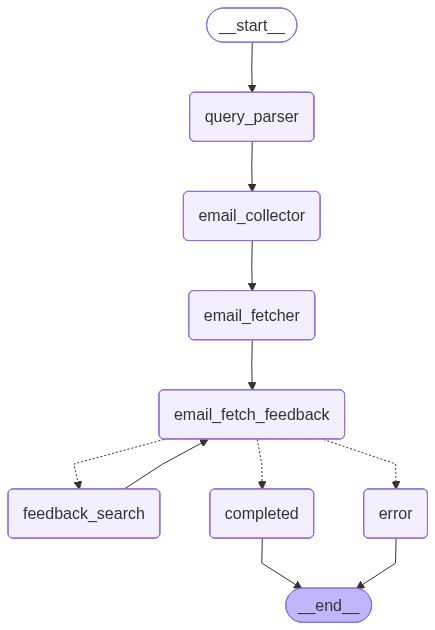

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xe2\x01\xd8ICC_PROFILE\x00\x01\x01\x00\x00\x01\xc8\x00\x00\x00\x00\x040\x00\x00mntrRGB XYZ \x07\xe0\x00\x01\x00\x01\x00\x00\x00\x00\x00\x00acsp\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\tdesc\x00\x00\x00\xf0\x00\x00\x00$rXYZ\x00\x00\x01\x14\x00\x00\x00\x14gXYZ\x00\x00\x01(\x00\x00\x00\x14bXYZ\x00\x00\x01<\x00\x00\x00\x14wtpt\x00\x00\x01P\x00\x00\x00\x14rTRC\x00\x00\x01d\x00\x00\x00(gTRC\x00\x00\x01d\x00\x00\x00(bTRC\x00\x00\x01d\x00\x00\x00(cprt\x00\x00\x01\x8c\x00\x00\x00<mluc\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x0cenUS\x00\x00\x00\x08\x00\x00\x00\x1c\x00s\x00R\x00G\x00BXYZ \x00\x00\x00\x00

In [6]:
def save_agent_diagram():
    """에이전트 워크플로우를 PNG 이미지로 저장"""
    
    agent = email_fetcher_agent()
    
    try:
        # PNG 이미지로 저장
        from IPython.display import Image, display
        
        # 이미지 생성 및 저장
        img_data = agent.get_graph().draw_mermaid_png()
        
        # 파일로 저장
        with open("email_agent_workflow.png", "wb") as f:
            f.write(img_data)
        
        print("✅ 워크플로우 다이어그램이 'email_agent_workflow.png'로 저장되었습니다!")
        
        # Jupyter에서 이미지 표시
        display(Image(img_data))
        
        return img_data
        
    except ImportError:
        print("❌ 이미지 생성을 위해 추가 패키지가 필요합니다:")
        print("pip install pygraphviz")
        return None
    except Exception as e:
        print(f"❌ 이미지 저장 오류: {str(e)}")
        return None

# 이미지 저장
save_agent_diagram()